In [ ]:
%%bash
# 把数据存到data_dir
data_dir="./data"
dataset_name="img_align_celeba"

if [ ! -d $data_dir ];then  # 文件夹不存在
  mkdir $data_dir
fi
cd $data_dir

if [ ! -d $dataset_name ];then
#   cp '/content/drive/My Drive/img_align_celeba.zip' './img_align_celeba.zip'
  wget https://hk1.hufan.ml/img_align_celeba.zip  
  unzip -q img_align_celeba.zip
  rm img_align_celeba.zip
  echo "complete to download the dataset"
else
  echo "You have downloaded the dataset"
fi
cd ..


In [3]:
data_dir = r'D:\python\Pytorch\data'
SAVE_PATH = './gan_model.pth'

# 深度卷积生成对抗神经网络（DC-GAN）

训练一个GAN生成新的名人照片

来源：https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#what-is-a-dcgan

# 生成对抗网络


## 什么是GAN

博弈的平衡点是当生成器生成的伪造品看起来像直接来自训练数据时，而鉴别器则总是猜测生成器输出是真实的还是伪造品的50％置信度。

x为输入图像，D(x)为判别器，输出x来自训练数据的概率；
z为从标准正态分布中采样得到的空间向量；G(z)为生成函数，估计训练数据来自的分布$p_{data}$，从而从评估的分布$p_g$中生成假数据。

所以D(G(z))为生成器生成真实图像的概率，D试图最大化正确分类的概率$log D(x)$，G试图最小化定义输出为假数据的概率$log(1-D(G(x))$，文章中GAN的损失函数为：
$$
\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}
$$
从理论上讲，此极小极大游戏的解决方案是$p_g = p_ {data}$，判别器会随机猜测输入是真实的还是假的。 但实际上，模型并不总是能达到此目的。

GANs are a framework for teaching a DL model to capture the training
data’s distribution so we can generate new data from that same
distribution. GANs were invented by Ian Goodfellow in 2014 and first
described in the paper [``Generative Adversarial
Nets``](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).
They are made of two distinct models, a *generator* and a
*discriminator*. The job of the generator is to spawn ‘fake’ images that
look like the training images. The job of the discriminator is to look
at an image and output whether or not it is a real training image or a
fake image from the generator. During training, the generator is
constantly trying to outsmart the discriminator by generating better and
better fakes, while the discriminator is working to become a better
detective and correctly classify the real and fake images. The
equilibrium of this game is when the generator is generating perfect
fakes that look as if they came directly from the training data, and the
discriminator is left to always guess at 50% confidence that the
generator output is real or fake.


Now, lets define some notation to be used throughout tutorial starting
with the discriminator. Let $x$ be data representing an image.
$D(x)$ is the discriminator network which outputs the (scalar)
probability that $x$ came from training data rather than the
generator. Here, since we are dealing with images the input to
$D(x)$ is an image of CHW size 3x64x64. Intuitively, $D(x)$
should be HIGH when $x$ comes from training data and LOW when
$x$ comes from the generator. $D(x)$ can also be thought of
as a traditional binary classifier.

For the generator’s notation, let $z$ be a latent space vector
sampled from a standard normal distribution. $G(z)$ represents the
generator function which maps the latent vector $z$ to data-space.
The goal of $G$ is to estimate the distribution that the training
data comes from ($p_{data}$) so it can generate fake samples from
that estimated distribution ($p_g$).

So, $D(G(z))$ is the probability (scalar) that the output of the
generator $G$ is a real image. As described in `Goodfellow’s
paper <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__,
$D$ and $G$ play a minimax game in which $D$ tries to
maximize the probability it correctly classifies reals and fakes
($logD(x)$), and $G$ tries to minimize the probability that
$D$ will predict its outputs are fake ($log(1-D(G(x)))$).
From the paper, the GAN loss function is

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

In theory, the solution to this minimax game is where
$p_g = p_{data}$, and the discriminator guesses randomly if the
inputs are real or fake. However, the convergence theory of GANs is
still being actively researched and in reality models do not always
train to this point.


## 什么是DC-GAN

DCGAN是上述GAN的直接扩展，卷积转置层可以使潜矢量可以转换为与图像形状相同的体积。

A DCGAN is a direct extension of the GAN described above, except that it
explicitly uses convolutional and convolutional-transpose layers in the
discriminator and generator, respectively. It was first described by
Radford et. al. in the paper [`Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks`](https://arxiv.org/pdf/1511.06434.pdf). The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution. The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations.  The
input is a latent vector, $z$, that is drawn from a standard
normal distribution and the output is a 3x64x64 RGB image. The strided
conv-transpose layers allow the latent vector to be transformed into a
volume with the same shape as an image. In the paper, the authors also
give some tips about how to setup the optimizers, how to calculate the
loss functions, and how to initialize the model weights, all of which
will be explained in the coming sections.


# 输入与预处理

In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999




Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs


In [5]:
# Root directory for dataset
dataroot = data_dir

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# 数据

使用数据集： Celeb-A Faces dataset(http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

需要把数据集放到data文件夹中
~~~
/path/to/data
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
~~~

This is an important step because we will be using the ImageFolder dataset class, which requires there to be subdirectories in the dataset’s root folder. Now, we can create the dataset, create the dataloader, set the device to run on, and finally visualize some of the training data.

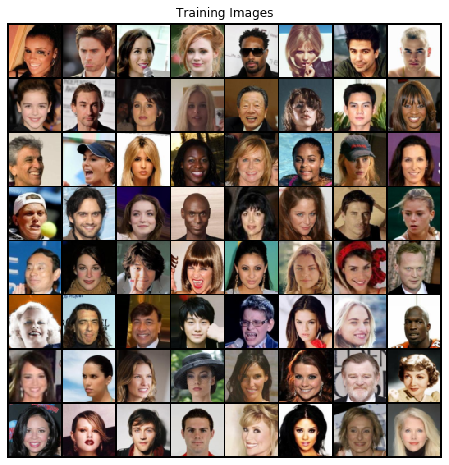

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

(64, 78)
(64, 64)


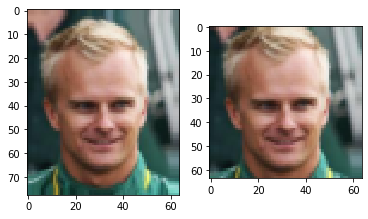

In [7]:
from PIL import Image

t_tran = []
t_tran.append(transforms.Resize(image_size))  # 64
t_tran.append(transforms.CenterCrop(image_size))


img = Image.open(data_dir + '/img_align_celeba/000013.jpg')
for i, tran in enumerate(t_tran):
    img = tran(img)
    print(img.size)
    plt.subplot(1, len(t_tran), i+1)
    plt.imshow(img)


# 训练

With our input parameters set and the dataset prepared, we can now get into the implementation. We will start with the weigth initialization strategy, then talk about the generator, discriminator, loss functions, and training loop in detail.


## 初始化权重

初始化权重为正太分布，均值0，标准差0.02.

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [8]:
# custom weights initialization called on netG and netD
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0.0)

## 生成器(Generator)

The generator, G, is designed to map the latent space vector (z) to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [−1,1]. It is worth noting `the existence of the batch norm functions after the conv-transpose layers`, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

![Generator.png](https://upload-images.jianshu.io/upload_images/20410282-888e164706359c2f.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

nz: 输入向量z的长度，ngf: 特征图的尺寸；nc: 输出图像的通道。

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.

In [9]:
# Generator code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) * 4 * 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        
    def forward(self, x):
        return self.main(x)

Now, we can instantiate the generator and apply the weights_init function. Check out the printed model to see how the generator object is structured.

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle muti-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## 判别器(discriminator)

As mentioned, the discriminator, D, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both G and D.

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the weights_init function, and print the model’s structure.

In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## 损失函数和优化器

loss function: [BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)
$$
\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}
$$

optimizer: Adam

We define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of  D  and  G , and this is also the convention used in the original GAN paper. Finally, we set up two separate optimizers, one for  D  and one for  G . As specified in the DCGAN paper, both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track of the generator’s learning progression, we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution (i.e. fixed_noise) . In the training loop, we will periodically input this fixed_noise into  G , and over the iterations we will see images form out of the noise.

In [13]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression
# of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## 训练

训练GAN实际上有点艺术？不正确的超参数设置可能会导致无法解释的失败，所以我们将：
- 严格遵守Goodfellow’s 论文中的设置
- 遵守[ganhacks](https://github.com/soumith/ganhacks)里面的一些最佳做法。（construct different mini-batches for real and fake）

### 第一部分，训练判别器

它的目标是最大化正确分类的概率(真假图像)，我们想使$log(D(x)) + log(1-D(G(z)))$最大化。Ganhacks建议用separate mini-batch，我们分两步计算：

1. 从训练集中选取一批真实数据，计算loss $log(D(x))$，以及梯度。
2. 从生成器数据中选取一批假数据，计算loss $log(1-D(G(z)))$，梯度。
3. 将以上两个相加，成为一步step。

### 第二部分，训练生成器

我们希望通过最小化log（1-D（G（z）））来训练Generator，以产生更好的伪造品。 如前所述，Goodfellow指出这不能提供足够的梯度，尤其是在学习过程的早期。 作为解决方法，我们改为希望最大化log（D（G（z）））。

在代码中，我们通过以下方式实现此目的：将第1部分的Generator输出与Discriminator进行分类，使用真实标签计算G的损失，然后反向传播计算梯度，最后通过优化器步骤更新G的参数。 将真实标签用作损失函数的GT标签似乎违反直觉，但这使我们可以使用BCELoss的log（x）部分（而不是log（1-x）部分），这正是我们想要的。

### 最后的统计

每一个epoch最后，我们会做一些统计报告，同时把固定随机向量(fixed_noise)输入生成器，追踪观察Generator的训练情况，训练统计数据为：

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as @@11@@
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.
 
**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.

In [14]:
# Training Loop  D_x, D_G_z 是用来统计的

# List to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print('Start Training Loop')

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with all-real batch  "log(D(x))"
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, ), real_label, device=device)  # fill a tensor with "1"
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)  # muti-dimention is turned into a vector
        # loss on all-real batch
        errD_real = criterion(output, label)
        # backward
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all fake batch, "log(1 - D(G(z)))"
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_input = netG(noise)
        label.fill_(fake_label)
        # classify all fake image batch with G
        output = netD(fake_input.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradient from the all-real and all-fake batches
        errD = errD_fake + errD_real
        
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake_input).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()
        
        # Output training status
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                netG.eval()
                fake_input = netG(fixed_noise).detach().cpu()
                netG.train()
            img_list.append(vutils.make_grid(fake_input, padding=2, normalize=True))
            
        iters += 1
        
        

Start Training Loop


..\aten\src\ATen\native\TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


tensor(1.1307, grad_fn=<BinaryCrossEntropyBackward>)


SystemExit: 0

C:\D_disk\Anaconda3\envs\my_ml\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 保存模型参数

https://pytorch.org/tutorials/beginner/saving_loading_models.html#

In [ ]:
# restore the model
torch.save({'netD': netD.state_dict(), 'netG': netG.state_dict()}, SAVE_PATH)

# 结果

Finally, lets check out how we did. Here, we will look at three different results. First, we will see how D and G’s losses changed during training. Second, we will visualize G’s output on the fixed_noise batch for every epoch. And third, we will look at a batch of real data next to a batch of fake data from G.

## loss-训练次数图
Below is a plot of D & G’s losses versus training iterations.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 可视化生成器（G）的进展

Remember how we saved the generator’s output on the fixed_noise batch after every epoch of training. Now, we can visualize the training progression of G with an animation. Press the play button to start the animation.

按按钮开始动画

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

ani.save("G_progression.gif",writer='pillow')
HTML(ani.to_jshtml())

## Real Images vs. Fake Images

Finally, lets take a look at some real images and fake images side by side.


In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Where to Go Next


We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here https://github.com/nashory/gans-awesome-applications`
-  Create GANs that generate
   `music https://deepmind.com/blog/wavenet-generative-model-raw-audio/`




In [ ]:
checkpoint = torch.load(SAVE_PATH)

In [ ]:
a = next(iter(dataloader))

In [ ]:
data = a

netD.zero_grad()
# Format batch
real_cpu = data[0].to(device)
b_size = real_cpu.size(0)
label = torch.full((b_size, ), real_label, device=device)  # fill a tensor with "1"
# Forward pass real batch through D
output = netD(real_cpu).view(-1)  # muti-dimention is turned into a vector
# loss on all-real batch
errD_real = criterion(output, label)
# backward
errD_real.backward()
D_x = output.mean().item()

## Train with all fake batch
# Generate batch of latent vectors
noise = torch.randn(b_size, nz, 1, 1, device=device)
fake_input = netG(noise)
label.fill_(fake_label)
# classify all fake image batch with G
output = netD(fake_input)

In [ ]:
output.shape